In [0]:
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [0]:
import keras

Using TensorFlow backend.
C:\Users\pramo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pramo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pramo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pramo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [0]:
img_list=[]
s=''
for pics in range(0,4198):
    st=str(pics)
    s='C:/Users/pramo/Downloads/face-to-bmi/Data/Resized_images_RGB_WITHOUTFAULT/img_'+st+'.bmp'
    img_list.append(s)

In [0]:
len(img_list)

4198

In [0]:
img_list[3]

'C:/Users/pramo/Downloads/face-to-bmi/Data/Resized_images_RGB_WITHOUTFAULT/img_3.bmp'

In [0]:
from keras.applications.vgg16 import VGG16

In [0]:
from keras.preprocessing import image

In [0]:
from keras.applications.vgg16 import preprocess_input

In [0]:
from keras.models import Model

In [0]:
#for extracting features  from specific layers(fc2)

base_model= VGG16(weights='imagenet')

model=Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
temp_x=1
for train_num in img_list:
    #images size should be 224*224 because vgg16 is pretrained on those dimensions

    img=image.load_img(train_num,target_size=(224,224))

    x=image.img_to_array(img)

    #inorder to create batch of images we need an additional dimension(size1,size2,channels) to (samples, size1,size2,channels)
    x=np.expand_dims(x,axis=0)

    x=preprocess_input(x)#its a mandatory statement to check if input satisfied dimensions needed

    features=model.predict(x)
    
    if(temp_x==1):
        deep_fea=features
        temp_x=0
    else:
        deep_fea=np.append(deep_fea,features,axis=0)#to add new rows to the X_image data

In [0]:
deep_fea.shape

(4198, 4096)

In [0]:
def export_X_train_vgg():
    return deep_fea

In [0]:
import pandas as pd

In [0]:
df=pd.read_csv('data_without_fault_images.csv')

In [0]:
df.columns

Index(['number', 'bmi', 'gender', 'is_training', 'name'], dtype='object')

In [0]:
df=df.drop(['number','is_training','name'],axis=1)

In [0]:
x_gen=df['gender']

In [0]:
y_train=df.loc[:,['bmi']]

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
number=LabelEncoder()
x_gen=number.fit_transform(x_gen.astype('str'))
x_gen=x_gen.reshape(4198,1)

In [0]:
x_gen.shape

(4198, 1)

In [0]:
X_train=np.append(x_gen,deep_fea,axis=1)
X_train.shape

(4198, 4097)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.5)

In [0]:
y_train.shape

(2099, 1)

In [0]:
from sklearn.linear_model import Ridge

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [0]:
#linear,rbf,poly shape of hyperplane that separates

Ridge_re=Ridge(fit_intercept=True, alpha=1, random_state=4, normalize=True)
Ridge_re=Ridge_re.fit(X_train,y_train)

In [0]:
#alp=[0.1,0.01,0.001,0.0001,0]#fitting the decision boundary line perfectly to the data points, higher values results ovefitting

#params={'alpha':alp}

#grid_ridge=GridSearchCV(Ridge_re,param_grid=params)
#model_grid=grid_ridge.fit(X_train,y_train)
#print(model_grid.best_params_)

In [0]:
prediction=Ridge_re.predict(X_test)

In [0]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
MSE=mean_squared_error(y_test,prediction)
score=Ridge_re.score(X_test,y_test)
MAE=mean_absolute_error(y_test,prediction)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("MSE={} and r2score={}, MAE={}, MAPE={}".format(MSE,score,MAE,MAPE))

MSE=64.86116422625325 and r2score=0.08651546414265654, MAE=6.1433216373712325, MAPE=18.766048167245085


In [0]:
from matplotlib import pyplot

Text(0,0.5,'predicted')

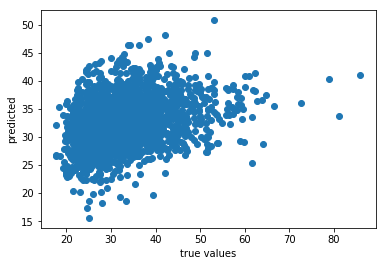

In [0]:
pyplot.scatter(y_test,prediction)
pyplot.xlabel('true values')
pyplot.ylabel('predicted')

In [0]:
#predicting on my own image
pramod=['C:/Users/pramo/Downloads/face-to-bmi/Data/Resized_images_RGB_WITHOUTFAULT/img_86.bmp']
temp_x=1
for train_num in pramod:
    #images size should be 224*224 because vgg16 is pretrained on those dimensions

    img=image.load_img(train_num,target_size=(224,224))

    x=image.img_to_array(img)

    #inorder to create batch of images we need an additional dimension(size1,size2,channels) to (samples, size1,size2,channels)
    x=np.expand_dims(x,axis=0)

    x=preprocess_input(x)#its a mandatory statement to check if input satisfied dimensions needed

    features=model.predict(x)
    
    if(temp_x==1):
        pra_fea=features
        temp_x=0
    else:
        pra_fea=np.append(pra_fea,features,axis=0)#to add new rows to the X_image data
pra_fea.shape
pra_gen=np.array([1])
pra_gen=pra_gen.reshape(1,1)
pra_fea=np.append(pra_gen,pra_fea,axis=1)
pra_fea.shape

In [0]:
Ridge_re.predict(pra_fea)

array([[33.64696162]])

In [0]:
from sklearn.svm import SVR

#gridsearchcv for SVR
gammas=[0.001,0.01,0.1,1,10]#higher gamma considers points near decision boundary
c=[0.1,1,10,100,1000]#fitting the decision boundary line perfectly to the data points, higher values results ovefitting
#linear,rbf,poly shape of hyperplane that separates
param_grid={'C':c,'gamma':gammas}
regression=SVR(kernel='rbf')
grid_search=GridSearchCV(regression,param_grid)
model_svr=grid_search.fit(X_train,y_train)
    #prediction=model.predict(X_test)
print(model_svr.best_params_)
   # MSE=mean_squared_error(y_test,prediction)
    #score=r2_score(y_test,prediction)
    #print("C:{},mean error{},r2score{}".format(g,MSE,score))

In [0]:
regression=SVR(C=10,gamma=0.001)

In [0]:
model_svr=regression.fit(X_train,y_train)

C:\Users\pramo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
prediction_svr=model_svr.predict(X_test)

In [0]:
MSE=mean_squared_error(y_test,prediction_svr)
score=model_svr.score(X_test,y_test)
MAE=mean_absolute_error(y_test,prediction_svr)
MAPE=mean_absolute_percentage_error(y_test,prediction_svr)
print("MSE={} and r2score={}, MAE={}, MAPE={}".format(MSE,score,MAE,MAPE))

MSE=63.94264362018339 and r2score=0.0994516237000811, MAE=5.999402689549772, MAPE=20.879285252109195


In [0]:
model_svr.predict(pra_fea)

array([42.64051419])